# Schematic

In [1]:
# 999-C1 Tag 2021-0416-1 mlr mri1

# Standard library imports
import sys
from datetime import datetime
from time import process_time
pt0 = process_time()
from time import time as wall_clock
wc0 = wall_clock()

# Third-Party Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy

import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

import xarray

# Local imports
import pystare
import starepandas

import scipy
# from scipy.spatial import ConvexHull

# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6

n_legend_colors = 8
LEGEND_COLORS = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))

usr_geoid = Geodesic()
km = 1

# 10 Colors
# LEGEND_COLORS = list(mcolors.TABLEAU_COLORS)

# 8 Colors
# LEGEND_COLORS = list(mcolors.BASE_COLORS)

# 148 Colors
#LEGEND_COLORS = list(mcolors.CSS4_COLORS)

# 949 Colors
# LEGEND_COLORS = list(mcolors.XKCD_COLORS)

# Define Classes and Functions
# ----------------------------

def divert_stderr():
    sys.stderr = open('stderr.out', 'w')
    return


def restore_stderr(_verbose=None):
    _verbose = (True if _verbose is None else _verbose)
    sys.stderr.close()
    if _verbose:
        with open('stderr.out') as f:
            count = sum(1 for _ in f)
        if count > 0:
            print(f"{count} warnings or errors encountered while stderr diverted. See stderr.out")
    sys.stderr = sys.__stderr__
    return


class FigAxContainer:
    def __init__(self, figax):
        self.fig = figax[0]  # class 'matplotlib.figure.Figure'
        self.ax = figax[1]   # class 'cartopy.mpl.geoaxes.GeoAxesSubplot'
        return


def add_coastlines(figax, set_global=None):
    """Add coastlines to the plot."""
    set_global = (False if set_global is None else set_global)
    if set_global:
        figax.ax.set_global()
    figax.ax.add_feature(cf.COASTLINE, linewidth=0.5, edgecolor='k')
    return figax


def hello_plot(spatial_index_values=None
               , figax=None, plot_options=None, set_global=None, set_coastlines=None
               , show_fig=None, color=None, lw=None, legend_label=None, use_dash=None
               , bbox_to_anchor=None
               , verbose=None
               , rasterized=None
              ):
    
    spatial_index_values = (None if spatial_index_values is None else spatial_index_values)
    figax = (None if figax is None else figax)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    set_global = (False if set_global is None else set_global)
    set_coastlines = (True if set_coastlines is None else set_coastlines)
    show_fig = (True if show_fig is None else show_fig)
    color = (None if color is None else color)
    lw = (1 if lw is None else lw)
    legend_label = (None if legend_label is None else legend_label)
    use_dash = (None if use_dash is None else use_dash)
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    verbose = (True if verbose is None else verbose)
    rasterized = (True if rasterized is None else rasterized)

    if figax is None:
        # Initialize the FigAxContainer the first time it is used
        figax = FigAxContainer(plt.subplots(1, subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()

    if spatial_index_values is not None:
        if isinstance(spatial_index_values,xarray.Dataset):
            lons = spatial_index_values.lons.data.reshape(3*len(spatial_index_values.htm))
            lats = spatial_index_values.lats.data.reshape(3*len(spatial_index_values.htm))
            intmat = spatial_index_values.intmat.data
        else:
            # Calculate vertices and interconnection matrix
            lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons, lats, intmat)

        divert_stderr()
        if use_dash is not None:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw,
                             label="Placeholder", dashes=use_dash, rasterized=rasterized)            
        else:
            figax.ax.triplot(siv_triang, c=color, transform=plot_options['transform'], lw=lw, 
                             label="Placeholder", rasterized=rasterized)
        restore_stderr(_verbose=verbose)
 
        # Add Legend
        if legend_label is not None:
            if isinstance(legend_label, list):
                # plt.triplot produces two legend entries. 
                #  The first of those are the edges
                #  The second contains the points (nodes).
                bbox_to_anchor = ( (1.7,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                the_handels, the_labels = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=the_handels[::2], labels=legend_label, bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False) 
            elif isinstance(legend_label, str):
                bbox_to_anchor = ( (1.4,1.0) if bbox_to_anchor is None else bbox_to_anchor )
                h, l = figax.ax.get_legend_handles_labels()
                figax.ax.legend(handles=[h[0]], labels=[legend_label], bbox_to_anchor=bbox_to_anchor
                                , loc='upper right', frameon=False)

    if show_fig:
        # Show figure now
        plt.show()

    return figax

def hex16(ival):
    return "0x%016x" % ival

def labeled_plot(sivs,figax,plot_labels=True
                 , bbox_to_anchor=None
                 , plot_options=None
                 , rasterized = None
                ):
    bbox_to_anchor = (None if bbox_to_anchor is None else bbox_to_anchor)
    plot_options = ({'projection': ccrs.PlateCarree()
                     , 'transform': ccrs.Geodetic()} if plot_options is None else plot_options)
    rasterized = ( True if rasterized is None else rasterized )
    
    # Plot each increment (overlay on common axes)
    legend_info = []
    n_legend_colors = len(sivs)
    legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
    
    for siv_idx, siv in enumerate(sivs):
        
        legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
        the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
        the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
        if len(legend_info[0]) < 32 or not plot_labels:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
        else:
            hello_plot(spatial_index_values=[siv], figax=figax, plot_options=plot_options
                       , bbox_to_anchor=bbox_to_anchor
                       , color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False
                       , lw=the_lw, use_dash=the_dash
                       , verbose=False
                       , rasterized=rasterized
                      )
            



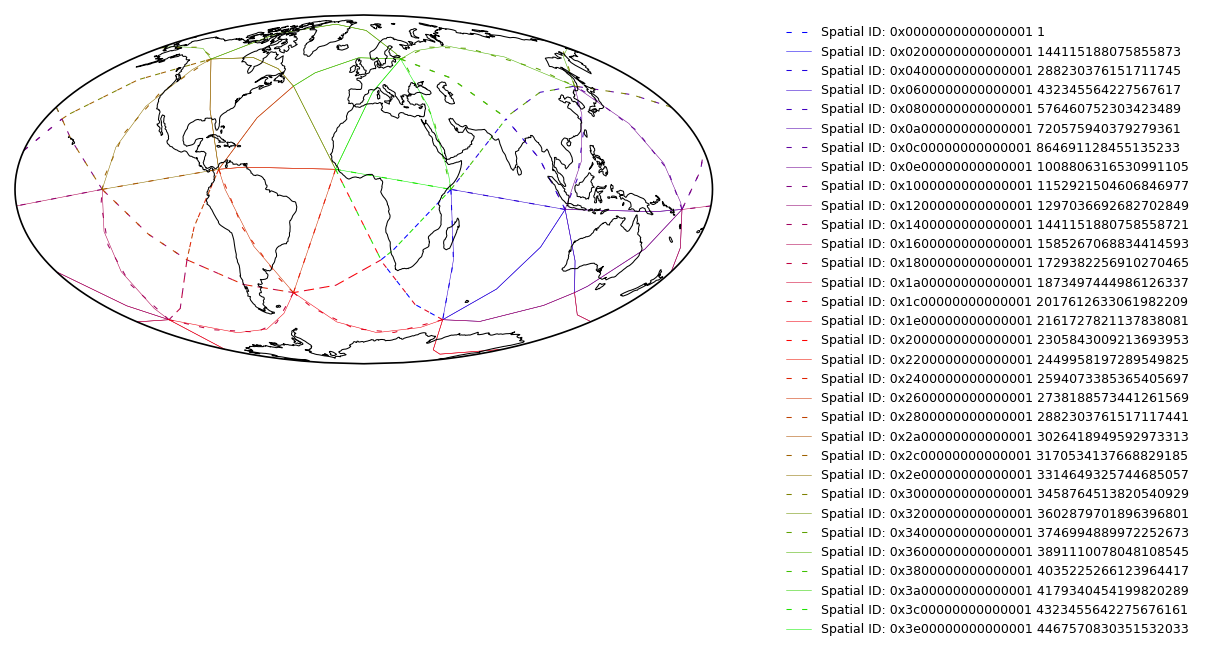

In [2]:
level = 1
level_increment = pystare.spatial_increment_from_level(level)

# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False, 
                                      show_fig=False, plot_options=usr_plot_options))

# Plot each increment (overlay on common axes)
legend_info = []
n_legend_colors = 8*(4**level)+1
legend_colors = plt.cm.brg(numpy.linspace(0, 1, n_legend_colors))
sivs = []
for siv_idx, siv in enumerate(range(0, (8 * (4**level)) * level_increment, level_increment)):
    siv = siv + level # Set the level
    sivs = sivs + [siv]
    # print(siv_idx,siv)
    legend_info.append(f"Spatial ID: {hex16(siv)} {siv}")
    the_dash = ((5, 10) if (siv_idx % 2) == 0 else ())
    the_lw = (0.5 if (siv_idx % 2) == 0 else 0.25)
    if len(legend_info[0]) < 32:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], show_fig=False, lw=the_lw, use_dash=the_dash, verbose=False)
    else:
        hello_plot(spatial_index_values=[siv], figax=usr_figax, plot_options=usr_plot_options, 
                   color=legend_colors[siv_idx], legend_label=legend_info, show_fig=False, 
                   lw=the_lw, use_dash=the_dash, verbose=False)

plt.show()
plt.close('all')
del usr_figax

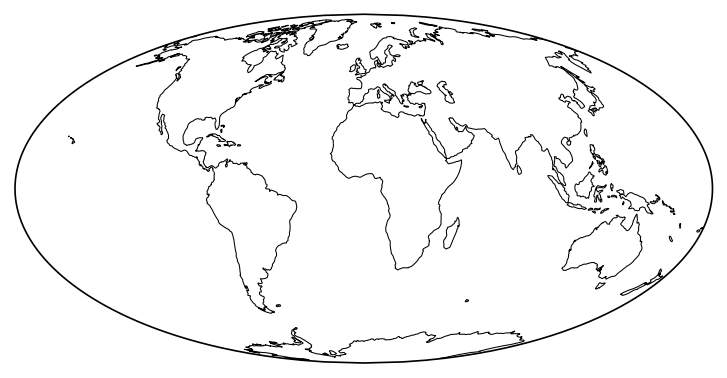

In [3]:
# Create a new figure axes instance using FigAxContainer instance via a call to hello_plot()
usr_figax = add_coastlines(hello_plot(set_coastlines=False, set_global=False, 
                                      show_fig=False, plot_options=usr_plot_options))

resolution (1000.000000 km) ~ level = 3, (float 3.356144)
(lon,lat)=(-155.602778,19.479444) -> spatial_id = 0x2c2401f47797ec43

Full spatial id:              0x2c2401f47797ec43
Geolocation part (bits 61-5): 0x2c2401f47797ec40
Resolution part  (bits  4-0): 0x0000000000000003


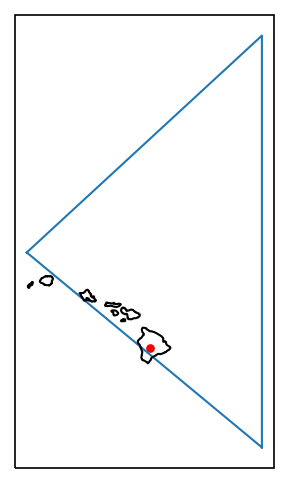

In [4]:
# Set longitude and latitude in degrees to the summit of Mauna Loa.
lon = -155.602778
lat =   19.479444

# Set the length scale of a neighborhood triangular element (trixel) about the location.
resolution_scale_km = 1000*km

# Determine the resolution, i.e. the level of the spatial quadtree, of that length scale.
spatial_resolution_level = int(pystare.spatial_resolution_from_km(resolution_scale_km))

# Calculate the spatial index value.
spatial_id = pystare.from_latlon([lat],[lon],spatial_resolution_level)

# Print to check.
print('resolution (%f km) ~ level = %i, (float %f)'%(resolution_scale_km
                                          ,spatial_resolution_level
                                          ,pystare.spatial_resolution_from_km(resolution_scale_km)))
print('(lon,lat)=(%f,%f) -> spatial_id = %s'%(lon,lat,hex16(spatial_id[0])))
print()
print('Full spatial id:              %s'%(hex16(spatial_id[0])))
print('Geolocation part (bits 61-5): %s'%(hex16(spatial_id[0] & (~31))))
print('Resolution part  (bits  4-0): %s'%(hex16(spatial_id[0] & ( 31))))

# Plot the trixel associated with the spatial index value
usr_figax = hello_plot(spatial_id,show_fig=False)
# usr_figax = add_coastlines(figax_container(plt.subplots(subplot_kw={'projection':proj,'transform':transf})))

# Plot the geolocation (lon,lat) as a red dot.
usr_figax.ax.scatter([lon],[lat],s=10,c='r')
plt.show()
del usr_figax

In [5]:
pystare.to_latlon(spatial_id)

(array([19.47944371]), array([204.39722202]))

In [6]:
lons, lats, intmat = pystare.triangulate_indices(spatial_id)

In [7]:
def make_cyclic(a):
    r = numpy.zeros(len(a)+1,dtype=a.dtype)
    r[:-1]=a; r[-1]=a[0]
    return r

In [8]:
make_cyclic(numpy.array([1,2,3]))

array([1, 2, 3, 1])

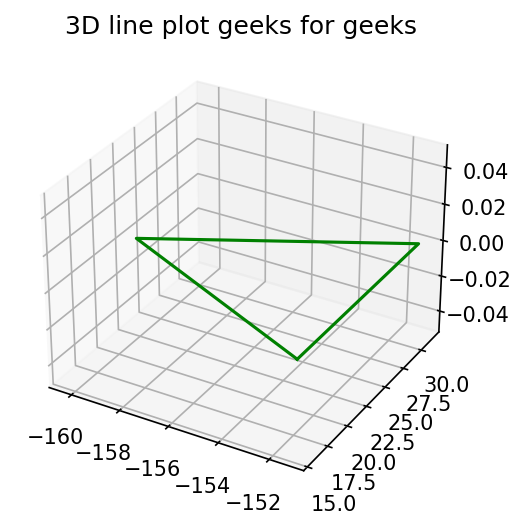

In [9]:
fig = plt.figure() 
  
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 
  
# defining all 3 axes 
z = 0.0
x = make_cyclic(lons)
y = make_cyclic(lats)
  
# plotting 
ax.plot3D(x, y, z, 'green') 
ax.set_title('3D line plot geeks for geeks') 
plt.show() 

In [10]:
from shapely.geometry import LineString

In [11]:
def delta(lonlat,geoid=None):
    if geoid is None:
        geoid=Geodesic()
    return geoid.geometry_length(LineString(lonlat))

In [12]:
delta([[0,0],[180,0]]) # = 20003931.458625447

20003931.458625447

In [13]:
def sgn(x,y):
    dx01=x[1]-x[0]
    dy01=y[1]-y[0]
    dx02=x[2]-x[0]
    dy02=y[2]-y[0]
    cp = dx01*dy02-dx02*dy01
    if cp > 0:
        return 1
    elif cp < 0:
        return -1
    else:
        return 0

In [14]:
def stare_plot_2s1t(
    figax=None
    ,spatial_index_values=None,temporal_index_values=None
    ,temporal_scales=0
    ,color_name='green',z0=0
    ,dbg=False
):
    
    if spatial_index_values is not None:
        if isinstance(spatial_index_values,xarray.Dataset):
            lons = spatial_index_values.lons.data.reshape(3*len(spatial_index_values.htm))
            lats = spatial_index_values.lats.data.reshape(3*len(spatial_index_values.htm))
            intmat = spatial_index_values.intmat.data
        else:
            # Calculate vertices and interconnection matrix
            lons, lats, intmat = pystare.triangulate_indices(spatial_index_values)

        # Make triangulation object & plot
        # siv_triang = tri.Triangulation(lons, lats, intmat)
        if dbg:
            print('lons shape: ',lons.shape)
            print('intm      : ',intmat)
        
    # print(intmat)
    for tr in intmat:
        if dbg:
            print('tr: ',tr)
        if temporal_scales is None:
            z = [z0]*4
        else:
            z = [z0]*4
            z1 = numpy.array([temporal_scales[int(tr[0]/3)]
                            ,temporal_scales[int(tr[1]/3)]
                            ,temporal_scales[int(tr[2]/3)]
                            ,temporal_scales[int(tr[0]/3)]])
        x = make_cyclic(numpy.array([lons[tr[0]],lons[tr[1]],lons[tr[2]]]))
        y = make_cyclic(numpy.array([lats[tr[0]],lats[tr[1]],lats[tr[2]]]))

        if dbg:
            print('==')
            print(sgn(x,y))
        
        thr = 180
        
        if sgn(x,y) < 0:
            if True:
                if abs(x[0]-x[1]) > thr:
                    if x[0] < x[1]:
                        x[0] += 360
                        x[3] = x[0]
                    else:
                        x[1] += 360
            if True:
                if abs(x[0]-x[2]) > thr:
                    if x[0] < x[2]:
                        x[0] += 360
                        x[3] = x[0]
                    else:
                        x[2] += 360            
            if True:
                if abs(x[1]-x[2]) > thr:
                    if x[1] < x[2]:
                        x[1] += 360.0
                    else:
                        x[2] += 360.0
                        
        if dbg:
            print(x)
            print(y)
            print(sgn(x,y))
            print('.')
    
        figax.ax.plot3D(x, y, z, color_name) 
        
        if temporal_scales is not None:
            figax.ax.plot3D(x, y, z1, color_name)
            for i in [0,1,2]:
                figax.ax.plot3D([x[i],x[i]],[y[i],y[i]],[z[i],z1[i]],color_name)
    
    return figax
    


In [15]:
len(sivs)

32

<Figure size 900x600 with 0 Axes>

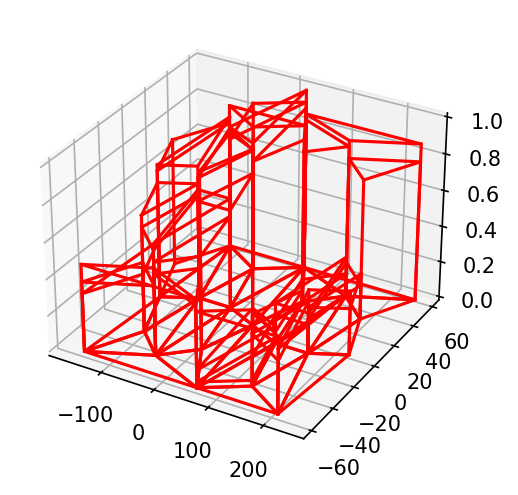

In [16]:
fig = plt.figure() 
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

temporal_scales = numpy.zeros([len(sivs)],dtype=numpy.double)
temporal_scales[:]=numpy.linspace(0, 1, len(sivs))
# print(temporal_scales.shape)

usr_figax = stare_plot_2s1t(
    figax = usr_figax
    ,spatial_index_values=sivs
    ,temporal_scales=temporal_scales
    ,color_name='red'
    ,dbg=False
)

if False:
    print('--')
    usr_figax = stare_plot_2s1t(
        figax = usr_figax
        ,spatial_index_values=sivs[15:16]
        ,z0=0.001
    )

usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

plt.show() 
del usr_figax

In [17]:
def plot_prism(bottom,top):
        figax.ax.plot3D(bottom.x,bottom.y,bottom) 
        
        if temporal_scales is not None:
            figax.ax.plot3D(x, y, z1, color_name)
            for i in [0,1,2]:
                figax.ax.plot3D([x[i],x[i]],[y[i],y[i]],[z[i],z1[i]],color_name)

In [18]:
import mpl_toolkits.mplot3d as a3

class stare_prism(object):
    
    def __init__(self,siv=None,tiv=None,color_reverse=None,color=None,color_forward=None,tiv_mock=None):
        self.siv = (None if siv is None else siv)
        self.tiv = (None if tiv is None else tiv)
        self.tiv_mock = ([0.0,0.33,0.67,1.0] if tiv_mock is None else tiv_mock)
        self.lons, self.lats, self.intmat = pystare.triangulate_indices([self.siv])
        
        if color_reverse is None and color is None and color_forward is None:
            self.color_reverse = 'red'
            self.color         = 'green'
            self.color_forward = 'blue'
        elif color is not None:
            self.color_reverse = (color if color_reverse is None else color_reverse)
            self.color         =  color
            self.color_forward = (color if color_forward is None else color_forward)
        else:
            self.color_reverse = ('red'   if color_reverse is None else color_reverse)
            self.color         = 'green'
            self.color_forward = ('blue'  if color_forward is None else color_forward)            
        
        return
    
    def plot1_simple(
        self
              ,figax
              ,alpha      = None
              ,edge_alpha = None
              ,edge_color = None
              ,prism_edge_color = None
              ,end_faces_plot = None
              ,side_face_edges_plot = None
              ,prism_side_face_edges_plot = None
             ):
        
        alpha               = (0.5 if alpha is None else alpha)
        edge_alpha          = (1 if edge_alpha is None else edge_alpha)
        end_faces_plot = ([True]*6 if end_faces_plot is None else end_faces_plot)
        side_face_edges_plot = ([True]*3 if side_face_edges_plot is None else side_face_edges_plot)
        prism_side_edges_plot = ([True]*3 if prism_side_face_edges_plot is None else prism_side_face_edges_plot)
        
        self.plot0(figax
                   ,color = self.color
                   ,edge_color = edge_color
                   ,prism_edge_color = prism_edge_color
                   ,alpha      = alpha
                   ,edge_alpha = edge_alpha                   
                   ,z=[self.tiv_mock[0],self.tiv_mock[-1]]
                   ,end_faces_plot = [end_faces_plot[0],end_faces_plot[-1]]
                   ,side_face_edges_plot = side_face_edges_plot
                   ,prism_side_face_edges_plot = prism_side_face_edges_plot
                  )

        return figax
    
    def plot1(self
              ,figax
              ,alpha      = None
              ,edge_alpha = None
              ,edge_color = None
              ,prism_edge_color = None
              ,end_faces_plot = None
              ,side_face_edges_plot = None
              ,prism_side_face_edges_plot = None
             ):
        
        alpha               = (0.5 if alpha is None else alpha)
        edge_alpha          = (0.5 if edge_alpha is None else alpha)
        side_face_edges_plot = ([True]*3 if side_face_edges_plot is None else side_face_edges_plot)
        prism_side_edges_plot = ([True]*3 if prism_side_face_edges_plot is None else prism_side_face_edges_plot)
        
        end_faces_plot = ([True]*6 if end_faces_plot is None else end_faces_plot)
        
        self.plot0(figax
                   ,color      = self.color_reverse
                   ,edge_color = edge_color
                   ,prism_edge_color = prism_edge_color
                   ,alpha      = alpha
                   ,edge_alpha = edge_alpha
                   ,z=self.tiv_mock[0:2]
                   ,end_faces_plot = end_faces_plot[0:2]
                   ,side_face_edges_plot = side_face_edges_plot
                   ,prism_side_face_edges_plot = prism_side_face_edges_plot
                  )
        self.plot0(figax
                   ,color = self.color
                   ,edge_color = edge_color
                   ,prism_edge_color = prism_edge_color
                   ,alpha      = alpha
                   ,edge_alpha = edge_alpha
                   ,z=self.tiv_mock[1:3]
                   ,end_faces_plot = end_faces_plot[2:4]
                   ,side_face_edges_plot = side_face_edges_plot
                   ,prism_side_face_edges_plot = prism_side_face_edges_plot
                  )
        self.plot0(figax
                   ,color = self.color_forward
                   ,edge_color = edge_color
                   ,prism_edge_color = prism_edge_color
                   ,alpha      = alpha
                   ,edge_alpha = edge_alpha
                   ,z=self.tiv_mock[2:4]
                   ,end_faces_plot = end_faces_plot[4:6]
                   ,side_face_edges_plot = side_face_edges_plot
                   ,prism_side_face_edges_plot = prism_side_face_edges_plot
                  )
        
        return figax
    
    def plot0(self
             ,figax
             ,z=None
             ,color=None
             ,edge_color=None
             ,prism_edge_color=None
             ,alpha=None
             ,edge_alpha=None
             ,end_faces_plot = None
             ,side_face_edges_plot = None
             ,prism_side_face_edges_plot = None
             ,dbg=None
            ):
        
        z          = ([0.0,1.0] if z is None else z)
        color      = ('grey' if color is None else color)
        edge_color = (None if edge_color is None else edge_color)
        prism_edge_color = (edge_color if prism_edge_color is None else prism_edge_color)
        alpha      = (0.5 if alpha is None else alpha)
        edge_alpha = (1.0 if edge_alpha is None else edge_alpha)
        end_faces_plot = ([True,True] if end_faces_plot is None else end_faces_plot)
        side_face_edges_plot = ([True]*3 if side_face_edges_plot is None else side_face_edges_plot);
        prism_side_edges_plot = ([True]*3 if prism_side_face_edges_plot is None else prism_side_face_edges_plot)
        dbg        = (False if dbg is None else dbg)
        
        # z0=self.tiv[0] # bad
        # temporal_scales = [self.tiv[1]]*4
        
        # print('side face edges plot: ',side_face_edges_plot)
        
        z0_ = z[0]
        z1_ = [z[1]]
        
        for tr in self.intmat:
            
            if dbg:
                print('tr: ',tr)
            if z1_ is None:
                z = [z0_]*4
            else:
                z = [z0_]*4
                z1 = numpy.array([z1_[int(tr[0]/3)]
                                ,z1_[int(tr[1]/3)]
                                ,z1_[int(tr[2]/3)]
                                ,z1_[int(tr[0]/3)]])
            x = make_cyclic(numpy.array([self.lons[tr[0]],self.lons[tr[1]],self.lons[tr[2]]]))
            y = make_cyclic(numpy.array([self.lats[tr[0]],self.lats[tr[1]],self.lats[tr[2]]]))

            if dbg:
                print('==')
                print(sgn(x,y))
        
            thr = 180
        
            if sgn(x,y) < 0:
                if True:
                    if abs(x[0]-x[1]) > thr:
                        if x[0] < x[1]:
                            x[0] += 360
                            x[3] = x[0]
                        else:
                            x[1] += 360
                if True:
                    if abs(x[0]-x[2]) > thr:
                        if x[0] < x[2]:
                            x[0] += 360
                            x[3] = x[0]
                        else:
                            x[2] += 360            
                if True:
                    if abs(x[1]-x[2]) > thr:
                        if x[1] < x[2]:
                            x[1] += 360.0
                        else:
                            x[2] += 360.0
                        
            if dbg:
                print(x)
                print(y)
                print(sgn(x,y))
                print('.')
                
                print('end_faces_plot: ',end_faces_plot)
    
            x=numpy.array(x)
            y=numpy.array(y)
            z=numpy.array(z)
    
            if end_faces_plot[0]:
                figax.ax.plot_trisurf(x,y,z
                                    ,color=color
                                    ,alpha=alpha
                                    )
            else:
                # This is stupid
                 figax.ax.plot_trisurf(x,y,z
                                    ,color=color
                                    ,alpha=0
                                    )               
        
            if z1 is not None:
                
                if dbg:
                    print(100)
                    
                if prism_edge_color is not None:
                    for i in [0,1,2]:
                        if prism_side_edges_plot[i]:
                            figax.ax.plot3D([x[i],x[i]],[y[i],y[i]],[z[i],z1[i]]
                                            ,c=prism_edge_color
                                            ,alpha=edge_alpha
                                           )                
                
                for i in [0,1,2]:
                    if True:
                    
                        fx = numpy.array( [x[i],x[i+1],x[i+1]] )
                        fy = numpy.array( [y[i],y[i+1],y[i+1]] )
                        fz = numpy.array( [z[i],z[i+1],z1[i]] )
                        
                        vtx = numpy.array(
                            [
                                [x[i],x[i+1],x[i+1]]
                                ,[y[i],y[i+1],y[i+1]]
                                ,[z[i],z[i+1],z1[i]]
                            ]
                        )
                        vtx = numpy.transpose(vtx)
                        if dbg:
                            print('vtx: ',vtx)
                        tri = a3.art3d.Poly3DCollection([vtx])
                        tri.set_facecolor(
                            color
                            # self.color_reverse
                            # mpl.colors.rgb2hex([0.5,0.5,0.5])
                        )
                        tri.set_alpha(alpha)
                        if side_face_edges_plot[i]:
                            tri.set_edgecolor(edge_color)
                        else:
                            tri.set_edgecolor(None)
                        figax.ax.add_collection3d(tri)
     
                        vtx = numpy.array(
                            [
                                [x[i],x[i+1],x[i]]
                                ,[y[i],y[i+1],y[i]]
                                ,[z[i],z1[i+1],z1[i]]
                            ]
                        )
                        vtx = numpy.transpose(vtx)
                        tri = a3.art3d.Poly3DCollection([vtx])
                        tri.set_color(color)
                        # tri.set_color(mpl.colors.rgb2hex([0.45,0.45,0.45]))
                        tri.set_alpha(alpha)
                        if side_face_edges_plot[i]:
                            tri.set_edgecolor(edge_color)
                        else:
                            tri.set_edgecolor(None)
                        figax.ax.add_collection3d(tri)
                    
            if end_faces_plot[0]:
                if prism_edge_color is not None:
                    figax.ax.plot3D(x, y, z
                        ,c=prism_edge_color
                        ,alpha=edge_alpha
                        ) 
                
            if end_faces_plot[1]:
                if prism_edge_color is not None:                    
                    figax.ax.plot3D(x, y, z1, c=prism_edge_color, alpha=edge_alpha) 
                figax.ax.plot_trisurf(x,y,z1,color=color,alpha=alpha)

        return figax
        

<Figure size 900x600 with 0 Axes>

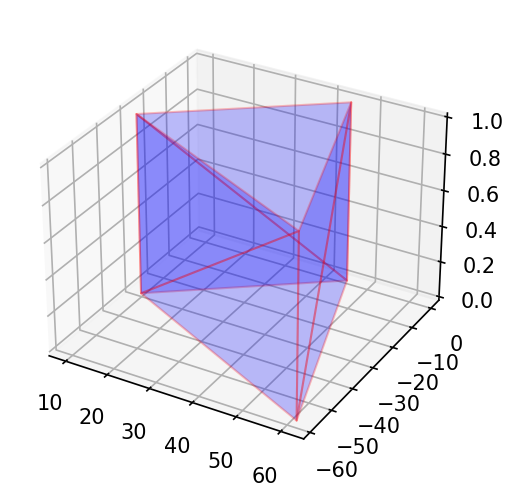

In [19]:
sp = stare_prism(siv=1,tiv=[0,1])

fig = plt.figure() 
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

# usr_figax = add_coastlines(usr_figax)

# ,colors=plt.cm.CMRmap
usr_figax = sp.plot0(
    usr_figax
    ,color='blue'
    ,alpha=0.25
    ,edge_color='r'
    ,prism_edge_color=None
    ,edge_alpha=0
    ,side_face_edges_plot = [True]*3
    ,end_faces_plot=[False,False]
)

usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

plt.show() 
del usr_figax

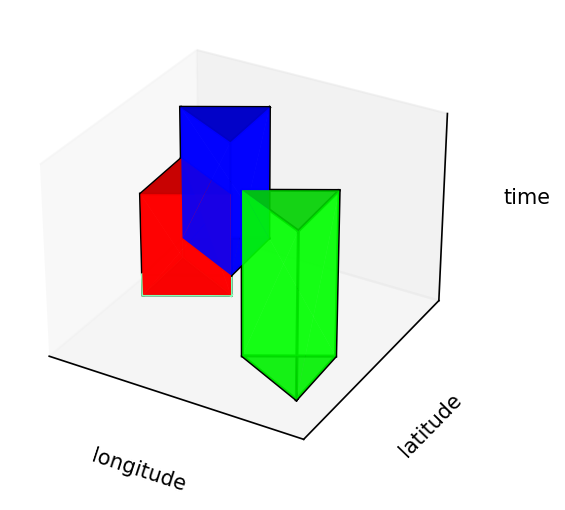

In [20]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

# usr_figax = hello_plot(spatial_id,show_fig=False)

cmap = mpl.cm.get_cmap('rainbow')

if False:
    sp = stare_prism(siv=1,tiv=[0,1]
    #                 ,color_reverse='red'
    #                 ,color='red'
    #                 ,color_forward='red'
                    )
    # ,colors=plt.cm.CMRmap
    sp.plot1(
        usr_figax
    #    ,color='blue'
        ,alpha=0.8
    #    ,prism_edge_color='k'
    #    ,edge_color='k'
    )

if False:
    for siv in [10,11,12,13,14]:
        sp = stare_prism(siv=siv,tiv=[0,1]
                         ,color=mpl.colors.rgb2hex([(siv-9.0)/5,0.5,(15-siv)/5])
                        )
        sp.plot1(
            usr_figax
            ,alpha=(siv-9)/6.0
            ,prism_edge_color='k'
        )

spatial_id[0] = (spatial_id[0] & (~31)) | 10
        
if True:
    spatial_increment = pystare.spatial_increment_from_level(spatial_id[0] & 31 )
    if True:
        siv = spatial_id[0]+spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=mpl.colors.rgb2hex([0,1,0])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         ,tiv_mock=numpy.array([0.2,0.7,0.9,1.75])
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.7
            ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )   
        
if True:
    for siv in spatial_id:
        sp = stare_prism(siv=siv,tiv=[0,1]
                         ,color=mpl.colors.rgb2hex([1,0,0])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.9
            ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )
        
    if True:
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(0.5)
                         # ,color=cmap(i*dcolor)
                         ,tiv_mock=numpy.array([0.0,0.001,0.002,0.2])
                        )
        
        end_faces_plot = [False]*6
        # end_faces_plot[0]=True
        # end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.0
            # ,edge_color='k'
            ,prism_edge_color=cmap(0.5)
            ,edge_alpha=1
            #,end_faces_plot=end_faces_plot
        )  

        
if True:
    spatial_increment = pystare.spatial_increment_from_level(spatial_id[0] & 31 )
    if True:
        siv = spatial_id[0]-spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.9
            ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )
        
        

                 
# usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

usr_figax.ax.get_xaxis().set_ticks([])
usr_figax.ax.set_xlabel('longitude')

usr_figax.ax.get_yaxis().set_ticks([])
usr_figax.ax.set_ylabel('latitude')

usr_figax.ax.get_zaxis().set_ticks([])
usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

In [21]:
spatial_increment = pystare.spatial_increment_from_level(spatial_id[0] & 31 )

In [22]:
print(hex(spatial_increment))

0x8000000000


In [23]:
print(spatial_id[0] & 31)

10


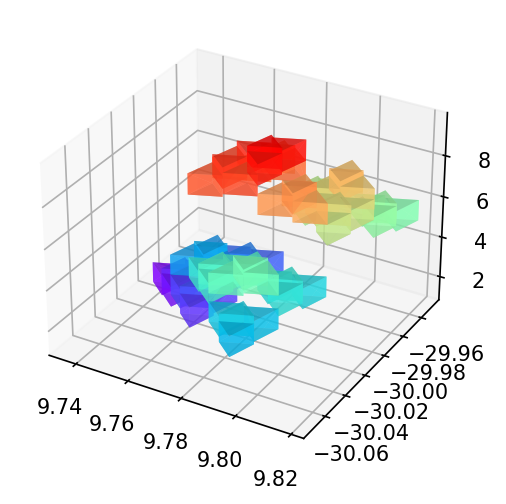

In [24]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

level  = spatial_id[0] & 31
dlevel = 3
spatial_increment = pystare.spatial_increment_from_level( level + dlevel )
# siv0 = (spatial_id[0]) + level + dlevel
siv0 = 0 + level + dlevel

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

dcolor = 1.0/(4**dlevel-1)

for i in range(4**dlevel):
# for i in [0,1,2,3]:
# for i in range(48,56):
    # print('i: ',i)
    
    if True:
        siv = siv0+i*spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(i*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])+i/8.0
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )  
        

plt.show() 
del usr_figax

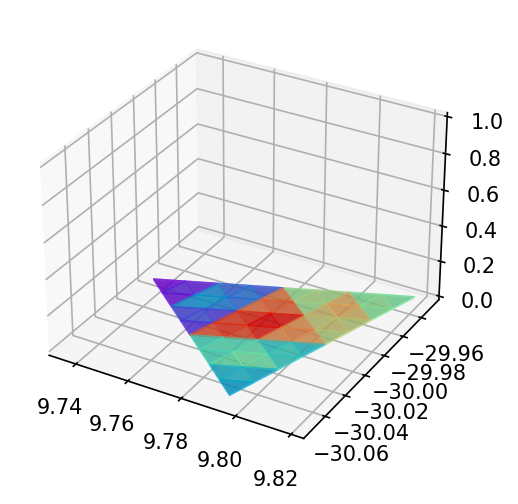

In [25]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

level  = spatial_id[0] & 31
dlevel = 3
spatial_increment = pystare.spatial_increment_from_level( level + dlevel )
# siv0 = (spatial_id[0]) + level + dlevel
siv0 = 0 + level + dlevel

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

dcolor = 1.0/(4**dlevel-1)

for i in range(4**dlevel):
# for i in [0,1,2,3]:
# for i in range(48,56):
    # print('i: ',i)
    
    if True:
        siv = siv0+i*spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(i*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.01
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )  
        
usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)
plt.show() 
del usr_figax

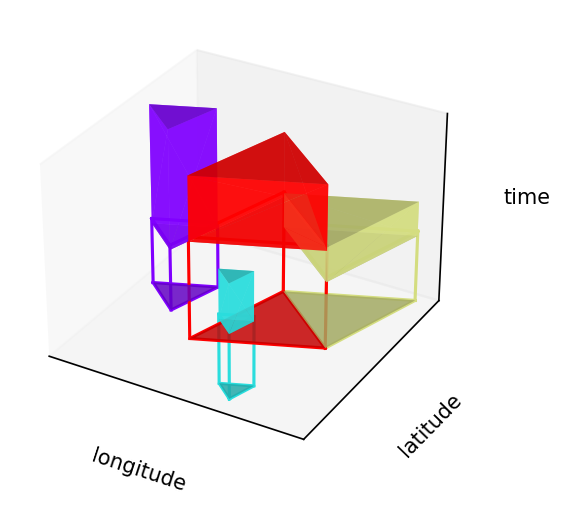

In [26]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

level  = spatial_id[0] & 31
dlevel = 1
spatial_increment = pystare.spatial_increment_from_level( level + dlevel )
# siv0 = (spatial_id[0]) + level + dlevel
siv0 = 0 + level + dlevel

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

dcolor = 1.0/(4**dlevel-1)

zscl=numpy.array([13.0,3.0,1.5,2])
zoff=numpy.array([0,0,0,6])+10
level_hack = numpy.array([1,2,0,0])
# print('zoff: ',zoff)

for i in range(4**dlevel):
# for i in [0,1,2,3]:
# for i in range(48,56):
    # print('i: ',i)
    
    if True:
        siv = siv0+i*spatial_increment+level_hack[i]
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(i*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         # delevel==3,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])+i/8.0+2
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,zscl[i]*(2.0+1.75*i)])+i*0.5+2+zoff[i]
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.75
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        ) 
        
    if True:
        # siv = siv0+i*spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(i*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.01
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )  
        
    if True:
        # siv = siv0+i*spatial_increment
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(i*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         # dlevel==3,tiv_mock=numpy.array([0.01,0.02,0.98,i/8.0+3])
                         ,tiv_mock=numpy.array([0.00,0.02,0.98,(i*0.5+4+zoff[i])])
                        )
        
        end_faces_plot = [False]*6
        # end_faces_plot[0]=True
        # end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.0
            # ,edge_color='k'
            ,prism_edge_color=cmap(i*dcolor)
            ,edge_alpha=1
            #,end_faces_plot=end_faces_plot
        )  
        
# usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=10.0)

# usr_figax.ax.set_xlim([-160,-140])
usr_figax.ax.get_xaxis().set_ticks([])
usr_figax.ax.set_xlabel('longitude')

# usr_figax.ax.set_ylim([20,40])
usr_figax.ax.get_yaxis().set_ticks([])
usr_figax.ax.set_ylabel('latitude')

usr_figax.ax.get_zaxis().set_ticks([])
usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax   
        
        

In [27]:
# lines = list(cf.COASTLINE.geometries())[107:112]
# multiline = shapely.geometry.MultiLineString(lines)
# print(len(list(cf.COASTLINE.geometries())))
# 4133

In [28]:
lines0 = list(cf.COASTLINE.with_scale('10m').geometries()) # Can be 10m, 50m, and 110m
print('len lines0: ',len(lines0))
if len(lines0) == 134:    # 110m
    line_idx = [107,108,109,110,111]
elif len(lines0) == 1428: # 50m
    line_idx = [802,803,804,805,806,807,808]
    # line_idx = [i for i in range(0,1399)]
elif len(lines0) == 4133: # 10m
    line_idx = [1672,1673,1675,1680,1685,1690,1699,1705]
else:
    print('cf.COASTLINE has unknown size or resolution')

len lines0:  4133


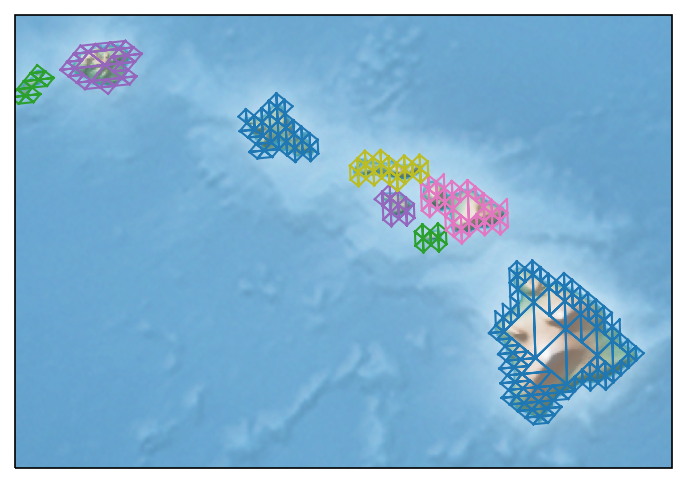

In [29]:
# Make covers from shapely polygons using non-convex hulls

figax = hello_plot(set_coastlines=False,set_global=False,show_fig=False)  

lines = [ lines0[i] for i in line_idx ]
multiline = shapely.geometry.MultiLineString(lines)

# figax.ax.add_geometries(multiline,cf.COASTLINE.crs,color='c',alpha=0.5)
# figax.ax.set_extent(numpy.array(multiline.bounds)[[0,2,1,3]])

# lons,lats = lonlat_from_coords(list(lines[0].coords))

# cover_resolution = 12
cover_resolution = 10

covers = []
for k in range(len(lines)):
#    lons,lats = lonlat_from_coords(list(lines[k].coords))
    covers = covers + [starepandas.from_polygon(shapely.geometry.polygon.orient(shapely.geometry.Polygon(lines[k]),1)
                                       ,level=cover_resolution,nonconvex=True)]
    
    #  ,resolution=cover_resolution,nonconvex=True)]
    
#    covers = covers + [pystare.to_nonconvex_hull_range_from_latlon(lats,lons,resolution=10)]
#    covers = covers + [pystare.to_hull_range_from_latlon(lats,lons,resolution=10)]

    # Default Cartopy background imagery
    # figax.ax.stock_img()

    # For an example of how to add imagery for background_img, see extras/05-FetchNaturalEarth-1.
    figax.ax.background_img(name='ne_shaded') # Identical to stock_img.
    # figax.ax.background_img(name='ne1_50m_sr_w')
    # figax.ax.background_img(name='ne1_10m_sr_w_dr')
    # figax.ax.background_img(name='hypso_50m_sr_w')
    figax.ax.background_img(name='hypso_10m_sr_ob_dr')

    
    # figax = hello_plot(pysta.expand_intervals(covers[k],8),figax,show=False)
    figax = hello_plot(covers[k],figax,show_fig=False)
                      
figax.ax.set_extent(numpy.array([-160.3, 18.5, -154.5, 22.5])[[0,2,1,3]])

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [30]:
pystare.__version__

'0.7.0'

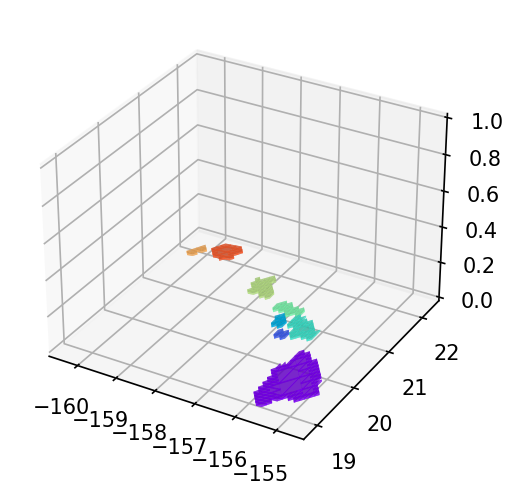

In [31]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

level  = spatial_id[0] & 31
dlevel = 3
spatial_increment = pystare.spatial_increment_from_level( level + dlevel )
# siv0 = (spatial_id[0]) + level + dlevel
siv0 = 0 + level + dlevel

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

# dcolor = 1.0/(4**dlevel-1)
dcolor = 1.0/(len(covers))

for icov in range(len(covers)):
# icov = 4
# if True:
    # dcolor = 1.0/len(covers[icov])

    for isiv in range(len(covers[icov])):
        siv = covers[icov][isiv]
        
        # print('color: ',isiv,isiv*dcolor,cmap(isiv*dcolor))
    
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(icov*dcolor)
                         #,color=cmap(isiv*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.01
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )  
        
usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)
plt.show() 
del usr_figax

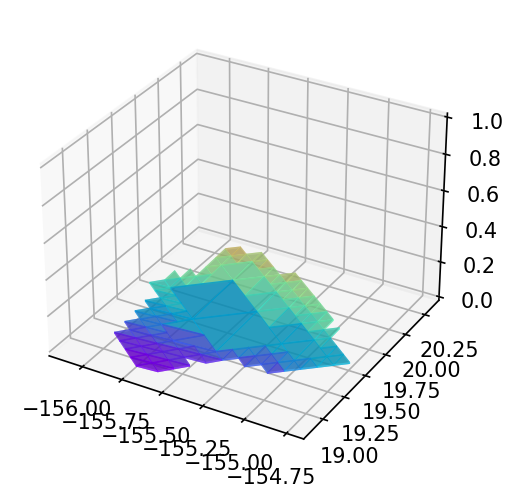

In [32]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

level  = spatial_id[0] & 31
dlevel = 3
spatial_increment = pystare.spatial_increment_from_level( level + dlevel )
# siv0 = (spatial_id[0]) + level + dlevel
siv0 = 0 + level + dlevel

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

dcolor = 1.0/(4**dlevel-1)


# for icov in range(len(covers)):
for icov in [0]:
    dcolor = 1.0/len(covers[icov])

    for isiv in range(len(covers[icov])):
        siv = covers[icov][isiv]
        lat,lon = pystare.to_latlon([siv])
        
        # print('color: ',isiv,isiv*dcolor,cmap(isiv*dcolor))
    
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         #,color=cmap(isiv*dcolor)
                         ,color=cmap((lat[0]-19.0)/1.9)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.01
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            # ,edge_color='k'
            # ,prism_edge_color='k'
            ,end_faces_plot=end_faces_plot
        )  
        
usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)
plt.show() 
del usr_figax

In [33]:
pystare.to_latlon([covers[4][0]])

(array([21.13495177]), array([203.14053125]))

In [34]:
covers_islands = covers

In [35]:
deg = 1.0

spatial_index_MaunaLoa = 0x2c2401f47797ec4b # Mauna Loa, ~ 5 km
finest_resolution = 10 # ~10km

# Make a cover centered on Mauna Loa
cover_MaunaLoa = pystare.circular_cover_from(spatial_index_MaunaLoa,1*deg,finest_resolution)

In [36]:
covers = [cover_MaunaLoa]

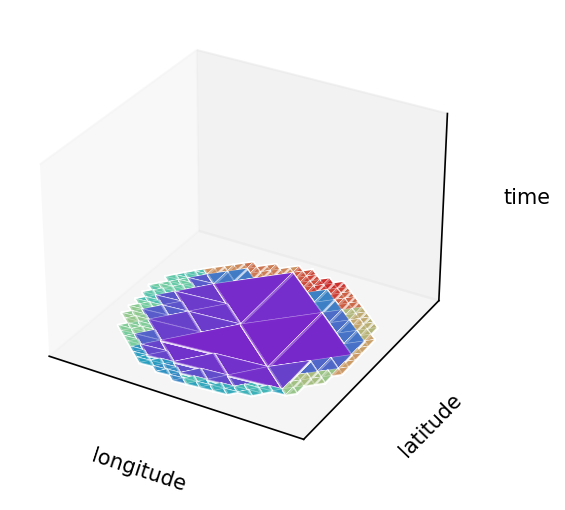

In [37]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

dcolor = 1.0/(4**dlevel-1)

# for icov in range(len(covers)):
for icov in [0]:
    dcolor = 1.0/len(covers[icov])

    for isiv in range(len(covers[icov])):
        siv = covers[icov][isiv]
        
        # print('color: ',isiv,isiv*dcolor,cmap(isiv*dcolor))
    
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(isiv*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         #,tiv_mock=numpy.array([0.25,0.7,0.9,1.5])*((1+i)/4.0)
                         ,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.001
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        sp.plot1_simple(
            usr_figax
            ,alpha=0.6
            ,edge_color='w'
            ,prism_edge_color='w'
            ,edge_alpha=1
            ,end_faces_plot=end_faces_plot
        )  
        
usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

# usr_figax.ax.set_xlim([-160,-140])
usr_figax.ax.get_xaxis().set_ticks([])
usr_figax.ax.set_xlabel('longitude')

# usr_figax.ax.set_ylim([20,40])
usr_figax.ax.get_yaxis().set_ticks([])
usr_figax.ax.set_ylabel('latitude')

usr_figax.ax.get_zaxis().set_ticks([])
usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

In [38]:
covers = []
dlon = 0.25
dlat = 0.25
for i in range(10):
    covers = covers + [pystare.circular_cover_from(pystare.from_latlon([20+i*dlat],[-156.0],27)[0],1,6+int(i/3)).tolist()]
    covers = covers + [pystare.circular_cover_from(pystare.from_latlon([15+i*dlat*0.25],[-154.0+3*i*dlon],27)[0],1,6+int(i/3)).tolist()]

In [39]:
# covers
def hull_from_cover(cover):
    lons,lats,intmat = pystare.triangulate_indices(cover)
    lonlat = numpy.stack([lons,lats]).T
    hull = scipy.spatial.ConvexHull(lonlat)
    # hull = None
    return (lonlat,hull)

def plot_hull(usr_figax,hull_tuple,t_mock,color=None):
    lonlat=hull_tuple[0]; hull=hull_tuple[1]
    for s in hull.simplices:
        x = lonlat[s,0]
        y = lonlat[s,1]
        z = numpy.full(x.shape,t_mock,dtype=x.dtype)
        usr_figax.ax.plot3D(x,y,z,c=color)
    return usr_figax

#                                            ,c=prism_edge_color
#                                            ,alpha=edge_alpha
    

In [40]:
hull_tuple = hull_from_cover(covers[0])

In [41]:
hull_tuple[0].shape

(30, 2)

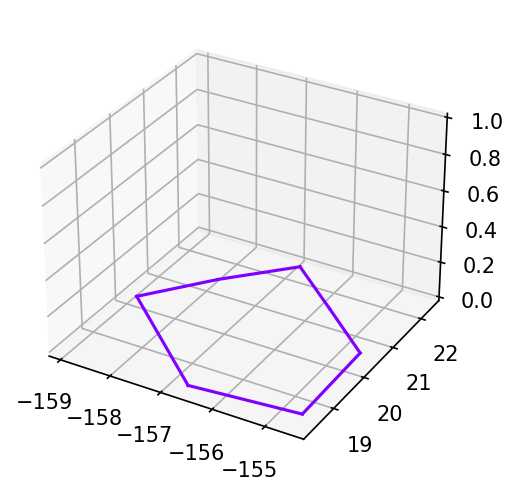

In [42]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

# usr_figax = plot_covers(usr_figax,covers=covers,cmap=cmap,color_key='covers')
usr_figax = plot_hull(usr_figax,hull_tuple,0,cmap(0))

usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

if False:
    # usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

    usr_figax.ax.set_xlim([-160,-150])
    usr_figax.ax.get_xaxis().set_ticks([])
    usr_figax.ax.set_xlabel('longitude')

    usr_figax.ax.set_ylim([15,25])
    usr_figax.ax.get_yaxis().set_ticks([])
    usr_figax.ax.set_ylabel('latitude')

    usr_figax.ax.get_zaxis().set_ticks([])
    usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

In [43]:


def plot_covers(
        usr_figax,covers=None,cmap=None,color_key=None
        ,end_faces_plot=None
        ,prism_edge_color_key=None
        ,alpha=None
        ,edge_alpha=None
        ,side_face_edges_plot=None
        ,prism_side_face_edges_plot=None
        ,plot_cell_flag=None
        ,plot_hull_flag=None
        ,hull_color_key=None
    ):
    if covers is None:
        return usr_figax
    
    color_key = ('covers' if color_key is None else color_key)
    hull_color_key = ('covers' if hull_color_key is None else hull_color_key)
    cmap = (None if cmap is None else cmap)
    
    if end_faces_plot is None:
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
    prism_edge_color_key = ('covers' if prism_edge_color_key is None else prism_edge_color_key)
    
    alpha = (None if alpha is None else alpha)
    edge_alpha = (None if edge_alpha is None else edge_alpha)
    
    side_face_edges_plot = ([True]*3 if side_face_edges_plot is None else side_face_edges_plot)
    prism_side_face_edges_plot = ([True]*3 if prism_side_face_edges_plot is None else prism_side_face_edges_plot)
    
    plot_cell_flag = ( True if plot_cell_flag is None else plot_cell_flag )
    plot_hull_flag = ( False if plot_hull_flag is None else plot_hull_flag )

    for icov in range(len(covers)):
        # for icov in [0]:
        if plot_cell_flag:
            for isiv in range(len(covers[icov])):

                siv = covers[icov][isiv]
            
                if color_key == 'covers' :
                    color = cmap(icov/len(covers))
                elif color_key == 'siv':
                    color = cmap(isiv/len(covers[icov]))
                else:
                    color = cmap(icov/len(covers))
        
                # print('color: ',isiv,isiv*dcolor,cmap(isiv*dcolor))
    
                sp = stare_prism(siv=siv,tiv=[0,0.5]
                                 ,color=color
                                 # ,color=mpl.colors.rgb2hex([0,0,1])
                                 # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                                 # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                                 ,tiv_mock=numpy.array([0.0,0.25,0.75,1.0])+icov
                                 #,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.001
                                )
        
                if prism_edge_color_key == 'covers' or prism_edge_color_key == 'siv':
                    prism_edge_color = color
        
                sp.plot1_simple(
                    usr_figax
                    ,alpha=alpha
                    ,edge_color=None
                    ,prism_edge_color=prism_edge_color
                    ,edge_alpha=edge_alpha
                    ,end_faces_plot=end_faces_plot
                    ,side_face_edges_plot=side_face_edges_plot
                    ,prism_side_face_edges_plot=prism_side_face_edges_plot
                )
        
        if plot_hull_flag:
            if hull_color_key == 'covers' :
                color = cmap(icov/len(covers))
            elif hull_color_key == 'siv':
                # color = cmap(isiv/len(covers[icov]))
                color = 'k'
            usr_figax = plot_hull(usr_figax,hull_from_cover(covers[icov]),icov,color=color)
            
    return usr_figax

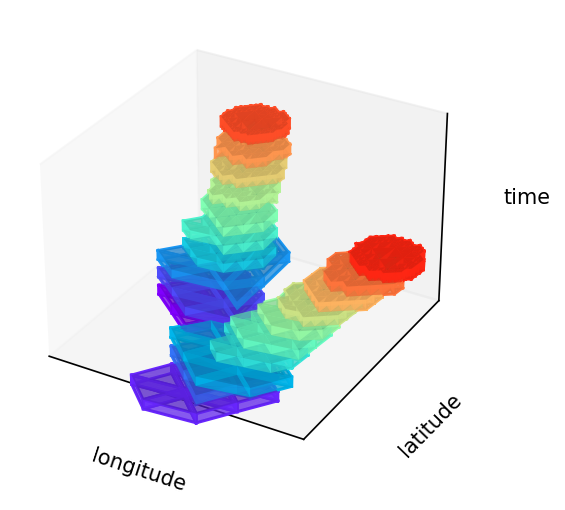

In [44]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

usr_figax = plot_covers(usr_figax,covers=covers,cmap=cmap,color_key='covers')

if True:
    # usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

    usr_figax.ax.set_xlim([-160,-150])
    usr_figax.ax.get_xaxis().set_ticks([])
    usr_figax.ax.set_xlabel('longitude')

    usr_figax.ax.set_ylim([15,25])
    usr_figax.ax.get_yaxis().set_ticks([])
    usr_figax.ax.set_ylabel('latitude')

    usr_figax.ax.get_zaxis().set_ticks([])
    usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

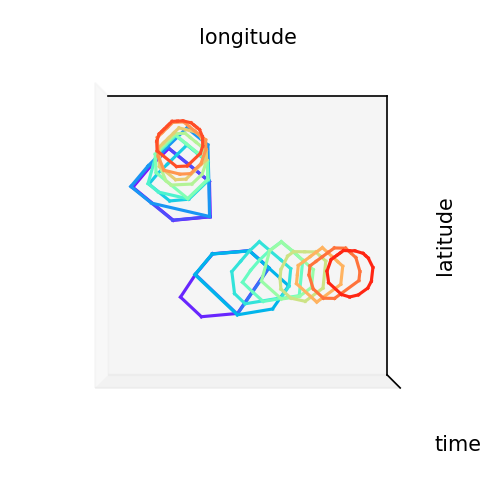

In [45]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)
# usr_figax,covers=[covers[0]],cmap=cmap,color_key='covers'

usr_figax = plot_covers(
    usr_figax
    ,covers=covers
    ,cmap=cmap
    ,color_key='covers'
    ,alpha=0.0
    ,edge_alpha=1
    ,prism_edge_color_key='covers'
    ,end_faces_plot=[True,False]
    ,side_face_edges_plot=[False,False,False]
    ,prism_side_face_edges_plot=[False,False,False]
    ,plot_cell_flag=False
    ,plot_hull_flag=True
    # ,hull_color_key='siv'
)

usr_figax.ax.view_init(elev=90.,azim=-90)
# usr_figax.ax.set_top_view()

if True:
    # usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

    usr_figax.ax.set_xlim([-160,-145])
    usr_figax.ax.get_xaxis().set_ticks([])
    usr_figax.ax.set_xlabel('longitude')

    usr_figax.ax.set_ylim([10,25])
    usr_figax.ax.get_yaxis().set_ticks([])
    usr_figax.ax.set_ylabel('latitude')

    usr_figax.ax.get_zaxis().set_ticks([])
    usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

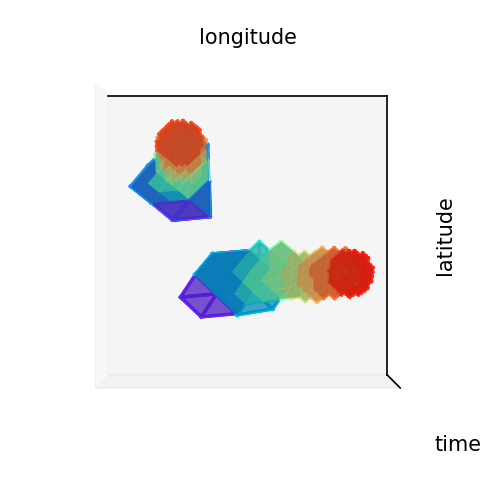

In [46]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

usr_figax = plot_covers(usr_figax,covers=covers,cmap=cmap,color_key='covers')

usr_figax.ax.view_init(elev=90.,azim=-90)

if True:
    # usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)

    usr_figax.ax.set_xlim([-160,-145])
    usr_figax.ax.get_xaxis().set_ticks([])
    usr_figax.ax.set_xlabel('longitude')

    usr_figax.ax.set_ylim([10,25])
    usr_figax.ax.get_yaxis().set_ticks([])
    usr_figax.ax.set_ylabel('latitude')

    usr_figax.ax.get_zaxis().set_ticks([])
    usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax

In [47]:
len(covers[0])

10

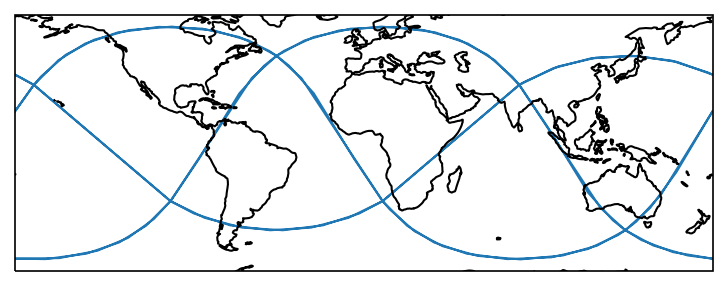

In [48]:
spatial_increment = pystare.spatial_increment_from_level( 0 )

world0 = numpy.array([0,1,2,3,4,5,6,7])*spatial_increment

usr_figax = hello_plot(world0,show_fig=False)
# usr_figax = add_coastlines(figax_container(plt.subplots(subplot_kw={'projection':proj,'transform':transf})))

# Plot the geolocation (lon,lat) as a red dot.
# usr_figax.ax.scatter([lon],[lat],s=10,c='r')
plt.show()
del usr_figax

In [49]:
print([(0, 0),  (0,1), (0.5, 0.5), (1, 1), (1, 0)])

[(0, 0), (0, 1), (0.5, 0.5), (1, 1), (1, 0)]


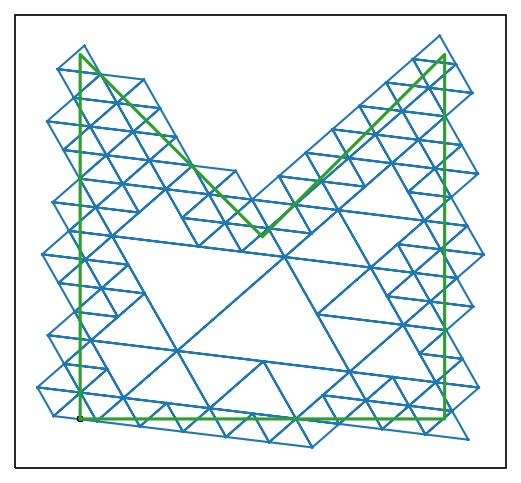

In [50]:
from shapely.geometry import Polygon
polygon_z0 = 1.05
polygon = Polygon([(0, 0, polygon_z0),  (0,1,polygon_z0), (0.5, 0.5,polygon_z0), (1, 1,polygon_z0), (1, 0, polygon_z0)])
polygon = shapely.geometry.polygon.orient(polygon)
polygon_cover = starepandas.from_polygon(polygon,level=10)

usr_figax = hello_plot(polygon_cover,show_fig=False)

plt.plot(*polygon.exterior.xy)

plt.show()
del usr_figax

In [51]:
covers=[polygon_cover]

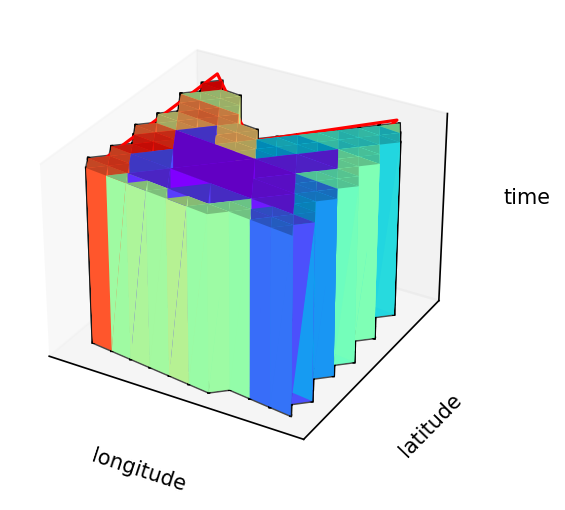

In [52]:
usr_figax = FigAxContainer((plt.figure(),plt.axes(projection='3d')))

if False:
    pex,pey,pez = zip(*polygon.exterior.coords)
    usr_figax.ax.plot3D(pex,pey,pez,c='r',alpha=1)

cmap = mpl.cm.get_cmap('rainbow')
# rgba = cmap(0.5)

# dcolor = 1.0/len(covers)
for icov in range(len(covers)):
# for icov in [0]:
    dcolor = 1.0/len(covers[icov])

    for isiv in range(len(covers[icov])):
#    for isiv in [0]:
        siv = covers[icov][isiv]
        
        # print('color: ',isiv,isiv*dcolor,cmap(isiv*dcolor))
    
        sp = stare_prism(siv=siv,tiv=[0,0.5]
                         ,color=cmap(isiv*dcolor)
                         #,color=cmap(icov*dcolor)
                         # ,color=mpl.colors.rgb2hex([0,0,1])
                         # ,color=mpl.colors.rgb2hex([0.5,0.5,0.5])
                         # ,tiv_mock=numpy.array([0.2,0.7,0.9,1.5])*(4.0/(1+i))**0.5
                         ,tiv_mock=numpy.array([0.0,0.25,0.75,1.0])+icov
                         #,tiv_mock=numpy.array([1.0,1.25,1.75,2.0])*0.001
                        )
        
        end_faces_plot = [False]*6
        end_faces_plot[0]=True
        end_faces_plot[5]=True
        
        if True:
            sp.plot1_simple(
                usr_figax
                ,alpha=1
                ,edge_color='w'
                ,prism_edge_color='k'
                #,prism_edge_color=cmap(isiv*dcolor)
                ,edge_alpha=0.7
                #,end_faces_plot=end_faces_plot
                ,end_faces_plot=[True,True]
                ,side_face_edges_plot=[False]*3
            )  

if True:
    pex,pey,pez = zip(*polygon.exterior.coords)
    usr_figax.ax.plot3D(pex,pey,pez,c='r',alpha=1)
        
# usr_figax.ax.axes.set_zlim3d(bottom=0.0,top=1.0)
# usr_figax.ax.set_xlim([-160,-150])

if True:
    usr_figax.ax.get_xaxis().set_ticks([])
    usr_figax.ax.set_xlabel('longitude')

    # usr_figax.ax.set_ylim([15,25])
    usr_figax.ax.get_yaxis().set_ticks([])
    usr_figax.ax.set_ylabel('latitude')

    usr_figax.ax.get_zaxis().set_ticks([])
    usr_figax.ax.set_zlabel('time')

plt.show() 
del usr_figax


# 2021-0210 Faces painted out of order. Matplotlib bug. MLR

In [53]:
import mayavi

ModuleNotFoundError: No module named 'mayavi'